In [5]:
!pip install numpy==1.24.4
!pip install pandas==1.4.4
!pip install matplotlib==3.5.2
!pip install sklearn==1.0.2
!pip install tensorflow==2.10.0

     --------------------------------------- 10.6/10.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1


ERROR: Could not find a version that satisfies the requirement sklearn==1.0.2 (from versions: 0.0, 0.0.post1, 0.0.post2, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11, 0.0.post12)
ERROR: No matching distribution found for sklearn==1.0.2


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import json

from pandas.core.frame import DataFrame
from collections import Counter
from sklearn.metrics import *

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential


from tensorflow.python.client import device_lib
from tensorflow.python.keras.utils.np_utils import to_categorical

In [5]:
# set the log device placement to true
tf.debugging.set_log_device_placement(True)

### Dataset analysis
This part is used to analyze the dataset, specifically, the label distribution of the dataset. And print some examples of the dataset to show the data structure.
This is important because the label distribution will affect the model training and validation, which can help us to choose the right evaluation metrics.

In [4]:
def path_join(file_name,dataset_path="../nyt_dataset"):
    """This function is used to join the path of the dataset and the file name"""
    final_path = os.path.join(dataset_path , file_name)
    return final_path

def label_distribution(data_File):
    """
    This function is used to analyze the label distribution of the dataset
    :param data_File: the path of the dataset
    :return: the label distribution of the dataset
    """
    df = pd.read_json(data_File,encoding="utf-8", orient='records')
    label=[df["relation_list"][i][0]["predicate"] for i in range(df.shape[0])]
    with open(path_join("rel2id.json"),"r") as f:
        rel2id = json.load(f)
        id2rel = {k:v for k, v in rel2id.items()}
        #num_classes = len(rel2id)
    train_label = [id2rel[i] for i in label]
    label_list = Counter(train_label)
    label_list=sorted(label_list.items(),key=lambda x:x[0],reverse=False)
    return label_list

def plot_label_distribution(label_Set,types="Training",figure_save_path="Data analysis"):
    """
    This function is used to plot the label distribution of the dataset
    :param labelSet: the label set of the dataset 
    :param types: the type of the dataset
    :param figure_save_path: the path to save the figure
    """
    x_r = [i[0] for i in label_Set]
    y_r = [i[1] for i in label_Set]
    plt.xticks(x_r, x_r) 
    plt.bar(x_r, y_r)
    plt.title("{} label distribution".format(types))
    if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path)
    plt.savefig(os.path.join("Data analysis" , '{} labels distributions.jpg'.format(types)))
    plt.show()

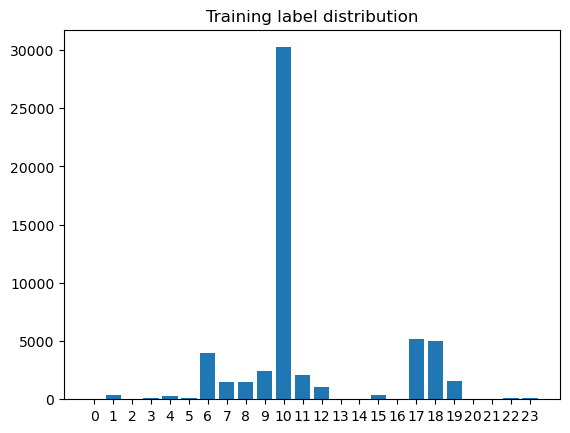

In [5]:
# plot the label distribution of the dataset
tr_set = label_distribution(path_join("train_data.json"))
plot_label_distribution(tr_set)

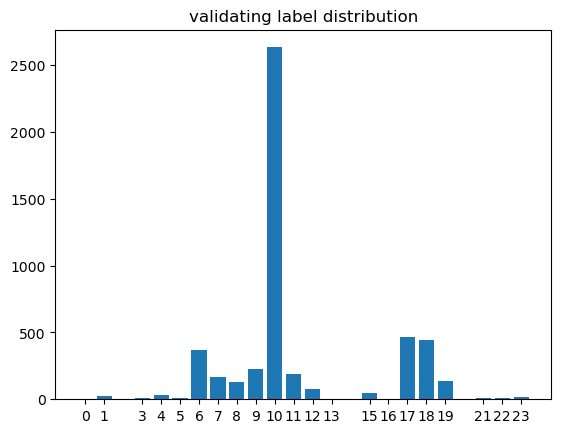

In [6]:
# plot the label distribution of the dataset
test_set = label_distribution(path_join("valid_data.json"))
plot_label_distribution(test_set,"validating")

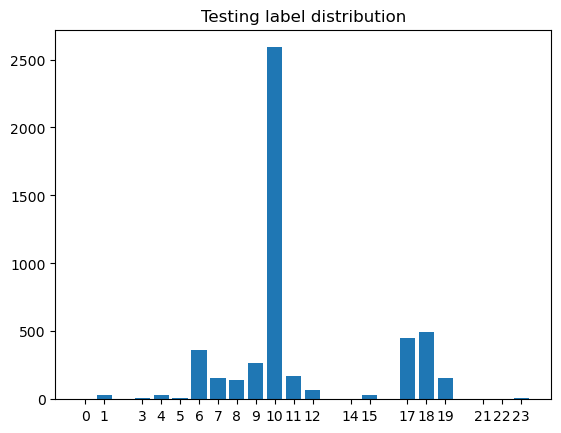

In [7]:
# plot the label distribution of the dataset
test_set = label_distribution(path_join("test_data.json"))
plot_label_distribution(test_set,"Testing")

In [8]:
df = pd.read_json(path_join("train_data.json"),encoding="utf-8", orient='records')
print(df)

                                                    text           id  \
0      Massachusetts ASTON MAGNA Great Barrington ; a...      train_0   
1      North Carolina EASTERN MUSIC FESTIVAL Greensbo...      train_1   
2      It will be the final movie credited to Debra H...      train_2   
3      In a 3-0 victory over the Crew on Saturday in ...      train_3   
4      The United States ambassador to Mexico , Tony ...      train_4   
...                                                  ...          ...   
56191  Tanna 's big draw is Mount Yasur , one of the ...  train_56191   
56192  We flew Air Pacific -LRB- 800-227-4446 ; www.a...  train_56192   
56193  I think Westchester is changing , '' said Kenn...  train_56193   
56194  Here we have a 172-acre island with four-star ...  train_56194   
56195  One was for St. Francis de Sales Roman Catholi...  train_56195   

                                           relation_list  \
0      [{'subject': 'Annandale-on-Hudson', 'object': ...   
1  

In [9]:
print(df['entity_list'][0])

[{'text': 'Annandale-on-Hudson', 'type': 'DEFAULT', 'char_span': [68, 87], 'tok_span': [17, 24]}, {'text': 'Bard College', 'type': 'DEFAULT', 'char_span': [53, 65], 'tok_span': [13, 16]}]


In [10]:
print(df['relation_list'][0])

[{'subject': 'Annandale-on-Hudson', 'object': 'Bard College', 'subj_char_span': [68, 87], 'obj_char_span': [53, 65], 'predicate': '/location/location/contains', 'subj_tok_span': [17, 24], 'obj_tok_span': [13, 16]}]


### Data preprocess
This part is used to process the dataset, including the following steps:
1. Tokenize the text data
2. Process the label data
3. Split the dataset into training, validating and testing dataset

In [14]:
# set the vocabulary size
n_most_common_words =30000
max_len = 100
#tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)

In [15]:
def data_process(train_file,valid_file,test_file):
    """
    This function is used to process the dataset
    :param train_file: the path of the training dataset 
    :param valid_file: the path of the validating dataset
    :param test_file: the path of the testing dataset
    :return: the training data, the training label, the validating data, the validating label, the testing data, the testing label
    """
    #tf.debugging.set_log_device_placement(True)
    relation_path = path_join("rel2id.json")
    df = pd.read_json(train_file,encoding="utf-8", orient='records')
    with open(relation_path,"r") as f:
        rel2id = json.load(f)
        id2rel = {k:v for k, v in rel2id.items()}
        #num_classes = len(rel2id)
        
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['text'].values)
    #print(len(tokenizer.word_index) + 1)
    
    # Process the data
    X_train = input_process(tokenizer,df,max_len)
    label_train = label_process(df,id2rel)
    
    df_valid = pd.read_json(valid_file,encoding="utf-8", orient='records')
    X_valid = input_process(tokenizer,df_valid,max_len)
    label_valid = label_process(df_valid,id2rel)
    
    df_test = pd.read_json(test_file,encoding="utf-8", orient='records')
    X_test = input_process(tokenizer,df_test,max_len)
    label_test = label_process(df_test,id2rel)
    
    return X_train, label_train, X_valid, label_valid, X_test, label_test, tokenizer


def input_process(tokenizer,df,max_len):
    """
    This function is used to process the input data
    :param tokenizer: the tokenizer
    :param df: the dataset
    :param max_len: the maximum length of the sentence
    :return:  the processed input data
    """
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    #word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def label_process(df_object,relate_label):
    """
    This function is used to process the label data
    :param df_object: the dataset
    :param relate_label: the label set
    :return: the processed label data
    """
    label=[df_object["relation_list"][i][0]["predicate"] for i in range(df_object.shape[0])]
    train_label = [relate_label[i] for i in label]
    labels=DataFrame(train_label)
    labels = to_categorical(labels, num_classes=24)
    return labels
    

In [16]:
# process the dataset before training
X_train, y_train, X_validation, y_validation,X_test,y_test,tokenizer = data_process(path_join("train_data.json"),path_join("valid_data.json"),path_join("test_data.json"))

In [15]:
print(X_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0   325
 10828  9306   348 10829    77    12  3733   187  4229    11   678   107
   275   406   117  1034]


In [27]:
y_train.shape

(56196, 24)

### Model generation
This part is used to generate and train the model. The model is a Bi-LSTM model with attention mechanism. 
Originally, the model is trained without the attention mechanism, but the accuracy is not good. For improving the accuracy, we add the attention mechanism to the model.

In [19]:
# define the attention layer 
class attention(Layer):
    """
    This class is used to define the attention mechanism(layer)
    """
    def __init__(self, return_sequences=True,**kwargs):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        """
        This function is used to build the attention mechanism
        :param input_shape: the input shape
        :return: the attention layer
        """
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        super(attention,self).build(input_shape)
        
    def call(self, x):
        """
        This function is used to call the attention mechanism
        :param x: the input data
        :return: the output data
        """
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
    
    def get_config(self):
        """
        This function is used to get the configuration of the attention mechanism
        :return: the configuration of the attention mechanism
        """
        config = super().get_config().copy()
        config.update({
            "return_sequences" : self.return_sequences,
        })
        return config

# initialize the weights for generating the model
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
def generate_model(embedding_size, n_most_common_words, output, learning_rate):
    """
    This function is used to generate the model
    :param embedding_size: the size of the embedding layer
    :param n_most_common_words: the vocabulary size
    :param output: the output size
    :param learning_rate: the learning rate
    :return: the model
    """
    model = Sequential()
    model.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
    model.add(Bidirectional(LSTM(output, dropout=0.7, recurrent_dropout=0.7,return_sequences=True)))
    model.add(attention(return_sequences=False))
    model.add(Dense(y_train.shape[1], activation='softmax',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.001)))
    model.compile(tf.keras.optimizers.Adam(lr = learning_rate),loss='categorical_crossentropy', metrics=['acc']) #categorical_crossentropy
    print(model.summary())
    return model

In [50]:
# generate the model
model = generate_model(100,n_most_common_words,120,0.0005)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          3000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 240)         212160    
 nal)                                                            
                                                                 
 attention_3 (attention)     (None, 240)               340       
                                                                 
 dense_2 (Dense)             (None, 24)                5784      
                                                                 
Total params: 3,218,284
Trainable params: 3,218,284
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" # allow the GPU memory to grow for training the model

In [37]:
# check the GPU status and the device list
print(tf.test.is_built_with_cuda())
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
print(device_lib.list_local_devices())

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4848012800028890172
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13882482248138388141
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


### Model training and validation

In [51]:
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data = (X_validation, y_validation),workers=4)
#model.fit(X_train, y_train, epochs=1, batch_size=128, validation_data = (X_validation, y_validation),workers=4)

Epoch 1/10
440/440 [==============================] - 334s 752ms/step - loss: 6.4279 - acc: 0.6004 - val_loss: 5.2840 - val_acc: 0.6762
Epoch 2/10
440/440 [==============================] - 334s 760ms/step - loss: 4.5202 - acc: 0.7152 - val_loss: 3.9681 - val_acc: 0.7016
Epoch 3/10
440/440 [==============================] - 332s 755ms/step - loss: 3.3516 - acc: 0.7587 - val_loss: 3.0593 - val_acc: 0.7156
Epoch 4/10
440/440 [==============================] - 329s 747ms/step - loss: 2.5220 - acc: 0.7917 - val_loss: 2.4477 - val_acc: 0.7254
Epoch 5/10
440/440 [==============================] - 331s 753ms/step - loss: 1.9194 - acc: 0.8192 - val_loss: 2.0462 - val_acc: 0.7226
Epoch 6/10
440/440 [==============================] - 329s 747ms/step - loss: 1.4772 - acc: 0.8364 - val_loss: 1.7189 - val_acc: 0.7192
Epoch 7/10
440/440 [==============================] - 330s 750ms/step - loss: 1.1550 - acc: 0.8534 - val_loss: 1.5059 - val_acc: 0.7260
Epoch 8/10
440/440 [============================

In [52]:
if not os.path.exists('../trained_model'):
        os.makedirs('../trained_model')
#model.save_weights(r'../trained_model/attention30k_100_120_5e-4.h5')
model.save(r'../trained_model/BiLSTM_with_attention.h5')
#model.save(r'model_data/attention_test.h5')

### Training and validation analysis
Draw the accuracy curve and loss curve corresponding to the training set and validation set

In [54]:
def show_train_history(train_history,train_metrics,val_metrics,figure_save_path="../result"):
    """
    This function is used to show the training history
    :param train_history: the training history
    :param train_metrics: the confusion matrix of the training set
    :param val_metrics: the confusion matrix of the validation set
    :param figure_save_path: the path to save the figure
    """
    plt.plot(train_history[train_metrics])
    plt.plot(train_history[val_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path)
    plt.savefig(os.path.join(figure_save_path , './{}{}.jpg'.format(train_metrics,0.0005)))
    plt.savefig()
    plt.show()


In [ ]:
# draw the accuracy curve and loss curve corresponding to the training set and validation set
show_train_history(model.history.history,'loss','val_loss')

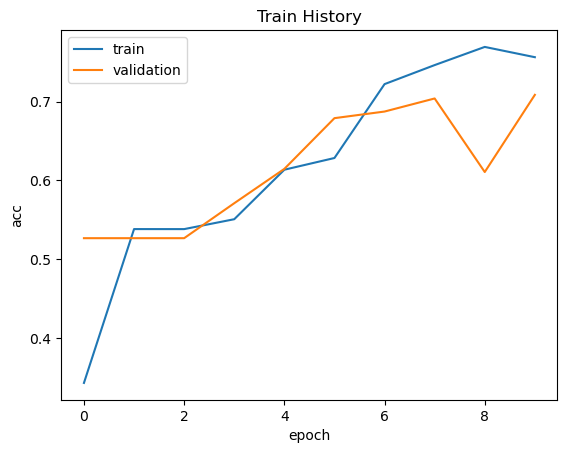

In [37]:
# draw the accuracy curve and loss curve corresponding to the training set and validation set
show_train_history(model.history.history,'acc','val_acc')

### Model testing

In [84]:
# predict the testing set
prediction_probas = model.predict(X_test) 

157/157 [==============================] - 12s 73ms/step


In [85]:
# calculate the confusion matrix and classification report
predictions = [np.argmax(pred) for pred in prediction_probas]
digit_y = [np.argmax(i)for i in y_test]
print(confusion_matrix(digit_y, predictions)) #from sklearn.metrics
print(classification_report(digit_y, predictions, digits=3))

[[   0    0    0    0    0    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    1    0    0    0   22    0    0    0    4    0    0    0    0
     0    0    2    0    0    0]
 [   0    0    0    0    0    8    0    0    0    3    0    0    0    0
     1    0    0    0    0    0]
 [   0    0    0    6    0    2    1    0    1   18    0    0    0    0
     0    1    0    0    0    0]
 [   0    0    0    0    0   12    0    0    0    0    0    0    0    0
     1    0    0    0    0    0]
 [   0    1    0    0    0  300    0    0    2   37    0    0    0    0
     7   12    1    0    0    0]
 [   0    0    0    0    0    1   46    0    6   86    0    0    0    0
    16    1    0    0    0    0]
 [   0    0    0    0    0    1   43    0    8   74    0    0    0    0
    12    4    0    0    0    0]
 [   0    0    0    0    0    1   12    0   49  171    0    1    0    0
    30    2    2    0    0    0]
 [   0    0    0    2    0   18   36    1   42 2373   2

C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Draw the heat-map of the confusion matrix

In [41]:
import seaborn as sns

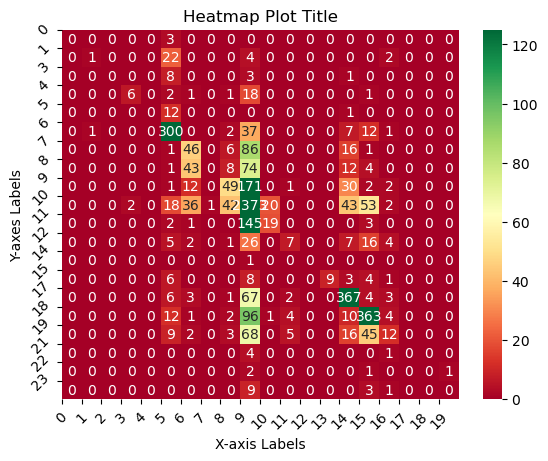

In [87]:
# draw the heat-map of the confusion matrix
text_str=[]
data = confusion_matrix(digit_y, predictions)
for i in range(20):
  x=[]
  for j in range(20):
    x.append(str(data[i][j]))
  text_str.append(x)
ax = sns.heatmap(data, cmap='RdYlGn',vmin=0, vmax=5**3, annot=text_str,fmt="")

xxx = [i for i in range(20)]
xxxs = [str(i) for i in range(20)]
plt.xticks(xxx,xxxs,rotation=45)
plt.yticks(xxx,('0','1','3','4','5','6','7','8','9','10','11','12','14','15','17','18','19','21','22','23'),rotation=45)

#We are imagining that the squares in the heat-map are function values corresponding to domain points, [20,40,60,80]x[100,200,300]
plt.title("Heatmap Plot Title")
plt.xlabel("X-axis Labels")
plt.ylabel("Y-axes Labels")
figure_save_path="Train_results"
if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path)
plt.savefig(os.path.join(figure_save_path , "HeatMap.jpg"))
plt.show()


### Predictor: Use the following predictor() to predict any sentence you want.

In [17]:
def predict_new_sentence(model,tokenizer,sentence):
    """
    This function is used to predict the relation of the sentence
    :param model: trained model
    :param tokenizer: the tokenizer 
    :param sentence: input sentence 
    :return: the relation of the sentence
    """
    x_tokens = sentence_process(tokenizer,sentence,100)
    vec = model.predict(x_tokens)
    prediction = [np.argmax(pred) for pred in vec]
    result = num_to_label(prediction)
    return result
    
def sentence_process(tokenizer,sentence,max_len):
    """
    This function is used to process the input sentence
    :param tokenizer: pointed tokenizer
    :param sentence: input sentence
    :param max_len: the maximum length of the sentence 
    :return: the processed input sentence
    """
    sequences = tokenizer.texts_to_sequences(sentence)
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def num_to_label(number):
    """
    This function is used to convert the number to the relation
    :param number: the encoded number of the relation
    :return: the encoded relation
    """
    with open(path_join("rel2id.json"),"r") as f:
        rel2id = json.load(f)
        t = {k:v for v, k in rel2id.items()}
    pred_label = [t[i] for i in number]
    return  pred_label

In [20]:
# load the model
model_load = tf.keras.models.load_model(r'../trained_model/BiLSTM_with_attention.h5',custom_objects={'attention':attention})
# predict the relation of an example sentence
#tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)

t1 = predict_new_sentence(model_load,tokenizer,["Jame go home.","Dan went to hotel."])
print(t1)

1/1 [==============================] - 3s 3s/step
['/location/location/contains', '/location/location/contains']
